<h1>Notbook do analizy wyników algorytmu PSO dla 1500 próbek po od 4-15 miast wykonanych dla różnych wartości warametrów alpha i beta z przedziału 0.1 - 0.9</h1>

1. Import bibliotek

In [72]:
import pandas as pd
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from builders.PathBuilder import PathBuilder
from constants.AlgNamesResults.names import *
from os.path import exists
import seaborn as sns
%matplotlib inline

2. Przygotowanie fuknkcjie i zmiennych do ekstrakcji danych z plików CSV

In [58]:
MEASUREMENTS = "measurements"
NAME_DIR_WITH_RESULTS_CSV = "pso_test_alpha_beta_range_from_0_1_to_0_9"
CSV = "csv"
CPU = "CPU"
TIME_AND_DATA = "TIME_AND_DATA"
TIME_AND_MEMORY = "TIME_AND_MEMORY"
DEFAULT_COLUMNS = ["number_of_cities", "index_of_sample", "type_of_measurement"]
FEATURE_COLUMNS = ["alpha", "beta"]
BASIC_COLUMNS = DEFAULT_COLUMNS + FEATURE_COLUMNS
CPU_COLUMNS = BASIC_COLUMNS + []
TIME_AND_DATA_COLUMNS = BASIC_COLUMNS + [
                                           "best_way_is_optimal",
                                           "relative_distance_error",
                                           "time_duration_is_sec "
                                          ]
TIME_AND_MEMORY_COLUMNS = BASIC_COLUMNS + []
#NAME OF PARAMETERS
ALPHA = "ALPHA"
BETA = "BETA"
CSV_NAME = "CSV_NAME"
def generate_config_combinations(type_of_measure):
    CONFIGURATIONS = list()
    pattern_suffix = "%s_PSO_POP_%d_ALPHA_%s_BETA_%s_NR_ITER_%d"
    size_population_range = 100
    alpha = 1
    beta= 2
    alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    beta_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    number_of_iterations_range = 100
    for alpha in alpha_range:
        for beta in beta_range:
            tmp_dictionary = dict()
            tmp_dictionary[ALPHA] = alpha
            tmp_dictionary[BETA] = beta
            alpha_str = str(alpha).replace(".", "_")
            beta_str = str(beta).replace(".", "_")
            name_of_csv = pattern_suffix % (type_of_measure,
                                            size_population_range,
                                            alpha_str,
                                            beta_str,
                                            number_of_iterations_range)
            tmp_dictionary[CSV_NAME] = name_of_csv
            CONFIGURATIONS.append(tmp_dictionary)
    return CONFIGURATIONS

def get_column_list(type_measurement):
    switcher = {
        TIME_AND_DATA: TIME_AND_DATA_COLUMNS,
        CPU: CPU_COLUMNS,
        TIME_AND_MEMORY: TIME_AND_MEMORY_COLUMNS
    }
    return switcher[type_measurement]
def get_file_name(type_measure, alpha_prop, beta_prop):
    pattern_suffix = "%s_PSO_POP_%d_ALPHA_%s_BETA_%s_NR_ITER_%d"
    alpha_str = str(alpha_prop).replace(".", "_")
    beta_str = str(beta_prop).replace(".", "_")
    return pattern_suffix % (type_measure, 100, alpha_str, beta_str, 100)

def prepare_csv_data_dictionary(type_of_measure, name_of_dir_with_meassurements):
    result_dictionary = dict()
    names = list()
    for csv_file_config in generate_config_combinations(type_of_measure):
        path_to_csv = PathBuilder()\
            .add_dir(MEASUREMENTS)\
            .add_dir(name_of_dir_with_meassurements)\
            .add_file(csv_file_config[CSV_NAME], "csv")\
            .build()
        if exists(path_to_csv):
            name_of_csv_file = csv_file_config[CSV_NAME]
            names.append(name_of_csv_file)
            result_dictionary[name_of_csv_file] = pd.read_csv(path_to_csv)
            result_dictionary[name_of_csv_file].dropna(axis=1, inplace=True)
            result_dictionary[name_of_csv_file].replace("Nan", "", inplace=True)
            result_dictionary[name_of_csv_file].insert(2, "alpha", [csv_file_config[ALPHA]] * result_dictionary[name_of_csv_file].count()[0], True)
            result_dictionary[name_of_csv_file].insert(3,"beta",[csv_file_config[BETA]] * result_dictionary[name_of_csv_file].count()[0], True)
            result_dictionary[name_of_csv_file] = result_dictionary[name_of_csv_file][get_column_list(type_of_measure)]
    return result_dictionary, names

csv_results_dict, names = prepare_csv_data_dictionary(TIME_AND_DATA, NAME_DIR_WITH_RESULTS_CSV)

3. Prezentacja danych z przykładowego pliku CSV

In [134]:
df = csv_results_dict["TIME_AND_DATA_PSO_POP_100_ALPHA_0_9_BETA_0_3_NR_ITER_100"]
df

,number_of_cities,index_of_sample,type_of_measurement,alpha,beta,best_way_is_optimal,relative_distance_error,time_duration_is_sec
0,4,0,TIME_AND_DATA,0.9,0.3,True,0.000000,0.002456
1,4,1,TIME_AND_DATA,0.9,0.3,True,0.000000,0.002825
2,4,2,TIME_AND_DATA,0.9,0.3,True,0.000000,0.002753
3,4,3,TIME_AND_DATA,0.9,0.3,True,0.000000,0.002766
4,4,4,TIME_AND_DATA,0.9,0.3,True,0.000000,0.002782
...,...,...,...,...,...,...,...,...
1195,15,95,TIME_AND_DATA,0.9,0.3,False,5.018408,0.116313
1196,15,96,TIME_AND_DATA,0.9,0.3,True,0.000000,0.113233
1197,15,97,TIME_AND_DATA,0.9,0.3,False,6.025722,0.101677
1198,15,98,TIME_AND_DATA,0.9,0.3,False,0.807284,0.158469


3. Opracowanie funkcji do zliczania danych

In [102]:

def generate_dictionary_alpha_beta(type_of_measure):
    configs = generate_config_combinations(type_of_measure)
    csv_results_by_alpha_beta = dict()
    for config in configs:
        name_of_csv = config[CSV_NAME]
        df = csv_results_dict[name_of_csv]
        alpha = config[ALPHA]
        beta = config[BETA]
        if alpha not in csv_results_by_alpha_beta:
            csv_results_by_alpha_beta[alpha] = dict()
            csv_results_by_alpha_beta[alpha][beta] = df
        else:
            csv_results_by_alpha_beta[alpha][beta] = df
    return csv_results_by_alpha_beta

def generate_data_fram_with_alpha_beta_and_optimal_percentage(csv_results_dict,type_of_measure, stat):
    # [NUMBER_OF_CITIES][4]-[15]
    # [0][MIN_RELATIVE_DISTANCE_ERROR]
    # .
    # [99]
    configs = generate_config_combinations(type_of_measure)
    names = csv_results_dict.keys()
    TABLE = dict()
    alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    beta_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    csv_results_by_alpha_beta = generate_dictionary_alpha_beta(type_of_measure)
    for alpha in alpha_range:
        for beta in beta_range:
            df = csv_results_by_alpha_beta[alpha][beta]
            series = df["best_way_is_optimal"]
            true_false_percentage = series.value_counts(normalize=True, ascending = True)
            value = 0.0
            if stat == "optimal_to_all_percentage":
                value = true_false_percentage[0]
            elif stat == "not_optimal_to_all_percentage":
                value = true_false_percentage[1]
            if alpha not in TABLE:
                TABLE[alpha] = list()
                TABLE[alpha].append(value)
            else:
                TABLE[alpha].append(value)
    return TABLE

def generate_data_fram_with_stats(csv_results_dict,type_of_measure,column_name,  stat):
    # [NUMBER_OF_CITIES][4]-[15]
    # [0][MIN_RELATIVE_DISTANCE_ERROR]
    # .
    # [99]
    configs = generate_config_combinations(type_of_measure)
    names = csv_results_dict.keys()
    TABLE = dict()
    alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    beta_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    csv_results_by_alpha_beta = generate_dictionary_alpha_beta(type_of_measure)
    for alpha in alpha_range:
        for beta in beta_range:
            df = csv_results_by_alpha_beta[alpha][beta]
            series = df[column_name]
            value = 0.0
            if stat == "min":
                value = series.min()
            elif stat == "avg":
                value = series.mean()
            elif stat == "max":
                value = series.max()
            elif stat == "stdev":
                value = series.std()
            elif stat == "sum":
                value = series.sum()
            elif stat == "log_sum":
                value = math.log(series.sum())
            elif stat == "q1":
                value = series.quantile(.25)
            elif stat == "q3":
                value = series.quantile(.75)
            if alpha not in TABLE:
                TABLE[alpha] = list()
                TABLE[alpha].append(value)
            else:
                TABLE[alpha].append(value)
    return TABLE     

4. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta obrazującej wartość procentową ilości znalezionych optymalnych rozwiązań z użyciem algorytmu PSO

Text(0.0, 1.0, 'PROCENT ZNALEZIONYCH OPTYMALNYCH ROZWIĄZAŃ DLA DANEJ WARTOŚCI PARAMETRU ALPHA I BETA DLA ALGORYTMU PSO')

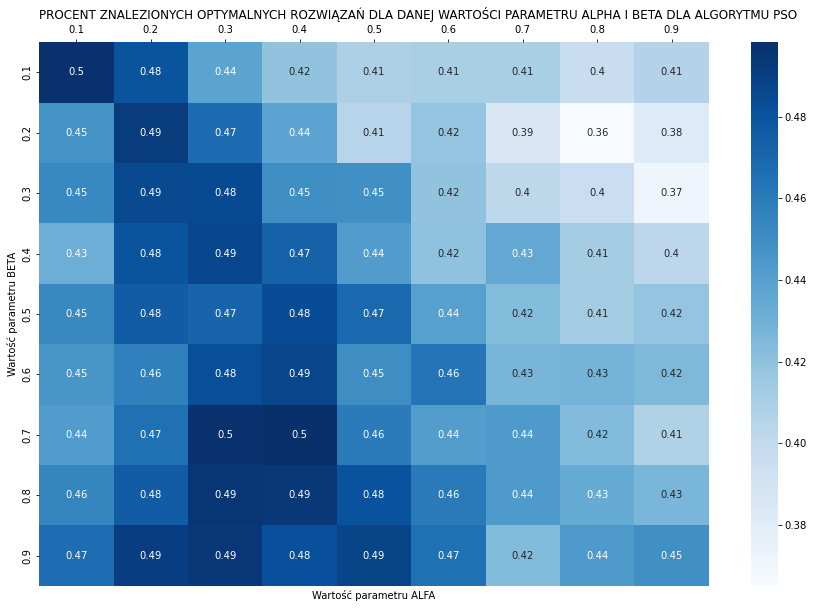

In [111]:
f = generate_data_fram_with_alpha_beta_and_optimal_percentage(csv_results_dict,
                                                              TIME_AND_DATA,
                                                              "optimal_to_all_percentage")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')

# title
title = 'Procent znalezionych optymalnych rozwiązań dla danej wartości parametru ALPHA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

5. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla sumy wartości błędów względnych

Text(0.0, 1.0, 'SUMA WARTOŚCI BŁĘDU WZGLĘDNEGO DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

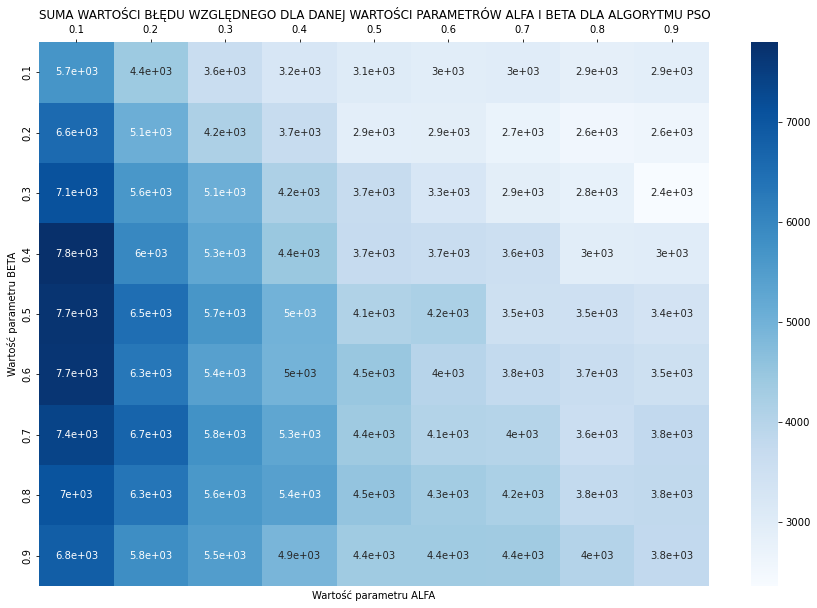

In [92]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "relative_distance_error",
                                  "sum")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Suma wartości błędu względnego dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

6. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla maksymalnej wartości błędu względnego

Text(0.0, 1.0, 'ŚREDNIA WARTOŚĆ BŁĘDU WZGLĘDNEGO DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

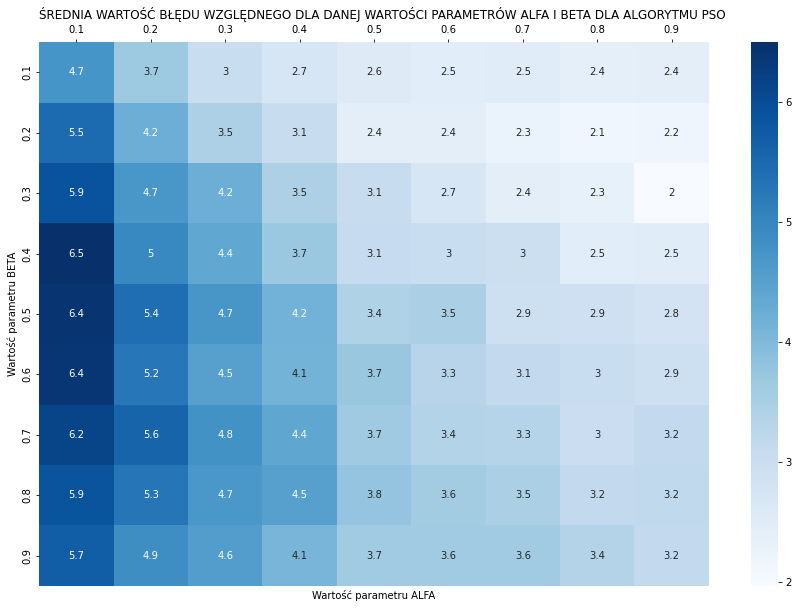

In [115]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "relative_distance_error",
                                  "avg")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Średnia wartość błędu względnego dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

7. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla średniej wartości błędu względnego

Text(0.0, 1.0, 'MAKSYMALNA WARTOŚĆ BŁĘDU WZGLĘDNEGO DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

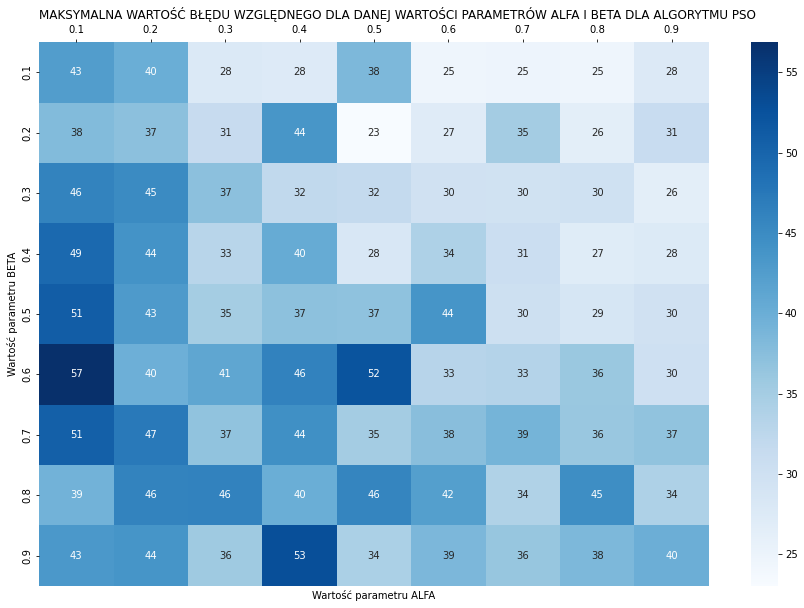

In [113]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "relative_distance_error",
                                  "max")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Maksymalna wartość błędu względnego dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

8. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla  wartości odchylenia standardowego błędu względnego

Text(0.0, 1.0, 'WARTOŚĆ ODCHYLENIA STANDARDOWEGO BŁĘDU WZGLĘDNEGO DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

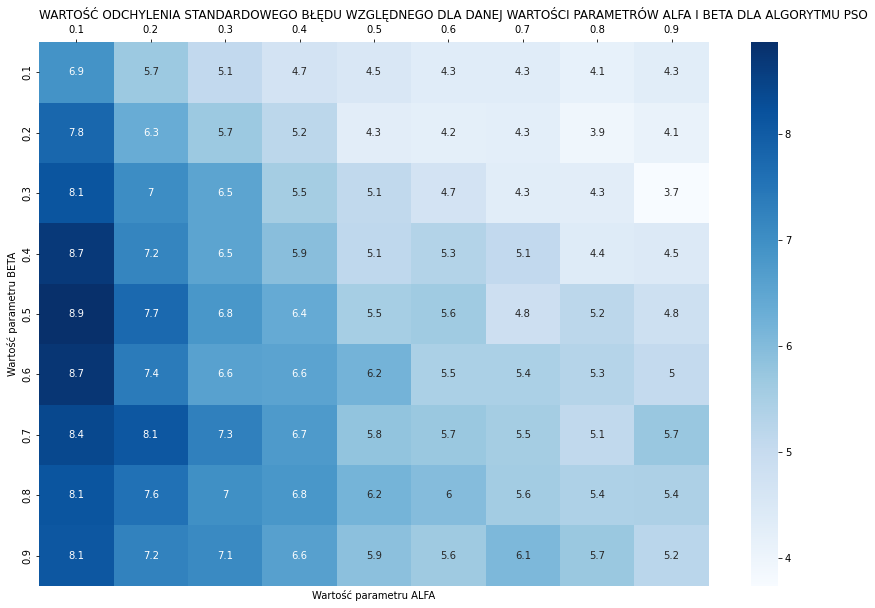

In [116]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "relative_distance_error",
                                  "stdev")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Wartość odchylenia standardowego błędu względnego dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

8. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla minimalnej długości czasu wykoanania algorytmu PSO w sekundach

Text(0.0, 1.0, 'MINIMALNA DŁUGOŚĆ WYKONANIA W SEKUNDACH DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

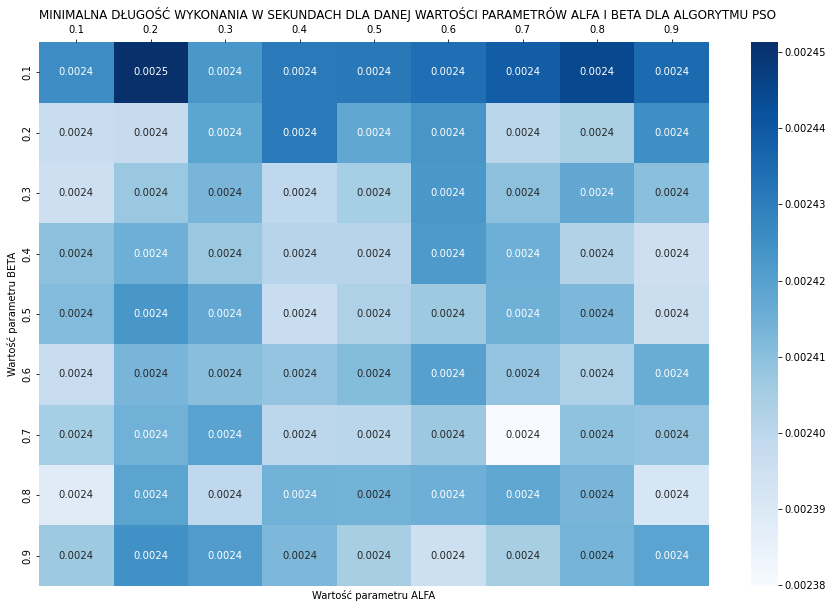

In [117]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "time_duration_is_sec ",
                                  "min")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Minimalna długość wykonania w sekundach dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

9. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla średniej długości czasu wykoanania algorytmu PSO w sekundach

Text(0.0, 1.0, 'ŚREDNIA DŁUGOŚĆ WYKONANIA W SEKUNDACH DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

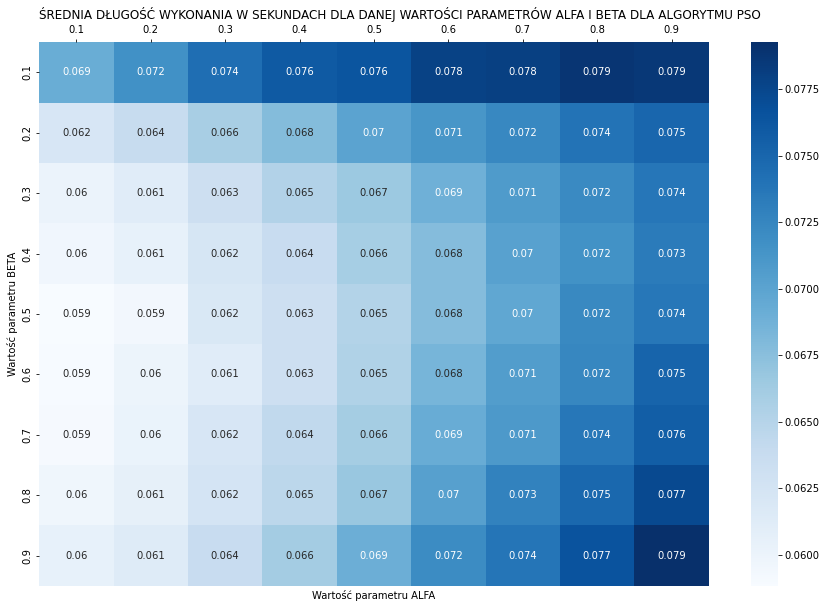

In [107]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "time_duration_is_sec ",
                                  "avg")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Średnia długość wykonania w sekundach dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

10. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla maksymalnej długości czasu wykoanania algorytmu PSO w sekundach

Text(0.0, 1.0, 'MAKSYMALNA DŁUGOŚĆ WYKONANIA W SEKUNDACH DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

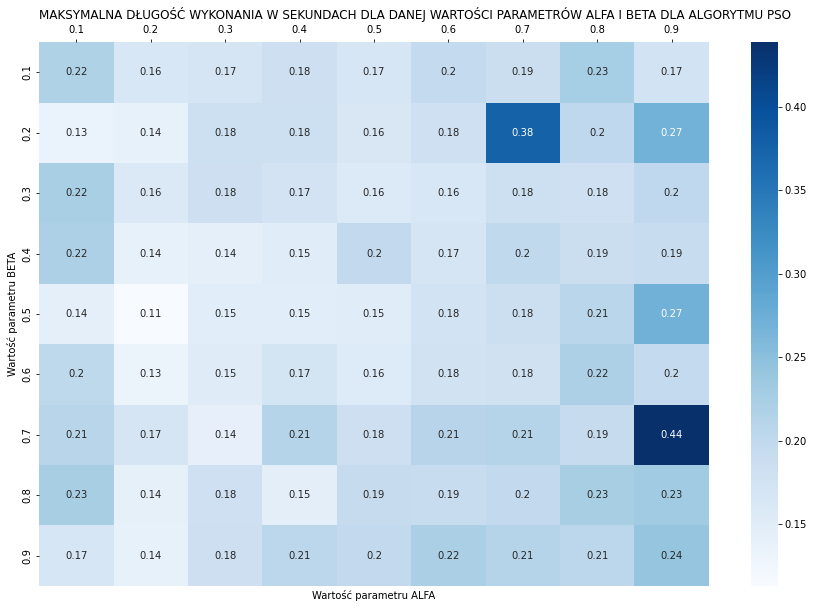

In [108]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "time_duration_is_sec ",
                                  "max")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Maksymalna długość wykonania w sekundach dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

11. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta dla wartośći odchylenia standardowego długości czasu wykoanania algorytmu PSO w sekundach

Text(0.0, 1.0, 'ODCHYLENIE STANDARDOWE DŁUGOŚCI WYKONANIA W SEKUNDACH DLA DANEJ WARTOŚCI PARAMETRÓW ALFA I BETA DLA ALGORYTMU PSO')

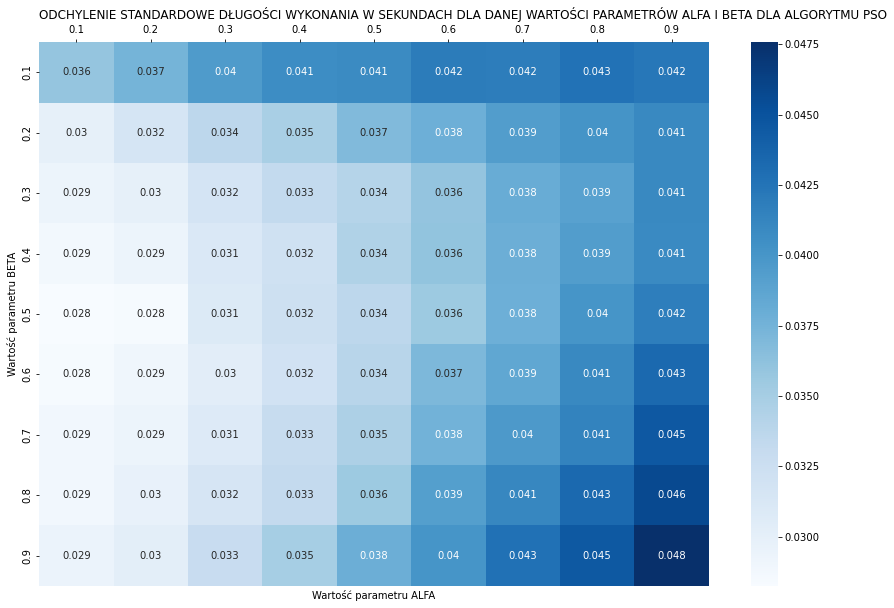

In [118]:
f = generate_data_fram_with_stats(csv_results_dict,
                                  TIME_AND_DATA,
                                  "time_duration_is_sec ",
                                  "stdev")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')
# title
title = 'Odchylenie standardowe długości wykonania w sekundach dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

In [130]:
def generate_data_frame_with_stats_from_number_cities(csv_results_dict,
                                                      type_of_measure,
                                                      alpha,
                                                      beta,
                                                      column_name,
                                                      stat):
    # [NUMBER_OF_CITIES][4]-[15]
    # [0][MIN_RELATIVE_DISTANCE_ERROR]
    # .
    # [99]
    configs = generate_config_combinations(type_of_measure)
    names = csv_results_dict.keys()
    LIST = list()
    number_of_cities_list = [4,5,6,7,8,9,10,11,12,13,14,15]
    csv_results_by_alpha_beta = generate_dictionary_alpha_beta(type_of_measure)
    df = csv_results_by_alpha_beta[alpha][beta]
    for number_of_cities in number_of_cities_list:
        condition = df[(df['number_of_cities'] == number_of_cities)]
        series = condition[column_name]
        value = 0.0
        if stat == "min":
            value = series.min()
        elif stat == "avg":
            value = series.mean()
        elif stat == "max":
            value = series.max()
        elif stat == "stdev":
            value = series.std()
        elif stat == "sum":
            value = series.sum()
        elif stat == "log_sum":
            value = math.log(series.sum())
        elif stat == "q1":
            value = series.quantile(.25)
        elif stat == "q3":
            value = series.quantile(.75)
        LIST.append(value)
    return LIST 

list_min
[0.0024101999999999, 0.0099058000000002, 0.0315841999999997, 0.0470024000000002, 0.0548812, 0.0578791, 0.0621789999999999, 0.0662150000000001, 0.0763680999999998, 0.0803289, 0.0861255999999999, 0.0868609]
list_avg
[0.002763492999999935, 0.012107859999999929, 0.038831624999999995, 0.056747234999999875, 0.06948520099999993, 0.07471100299999996, 0.08425652099999993, 0.0882393499999999, 0.09689384799999991, 0.1069938499999999, 0.11832631099999993, 0.1351329169999999]
list_max
[0.0046368000000001, 0.0255917000000001, 0.0573627999999999, 0.0854713, 0.1036246999999996, 0.1017793999999998, 0.1364659000000001, 0.1731374000000003, 0.1413907000000001, 0.1714741000000001, 0.1719163000000003, 0.2014097999999999]


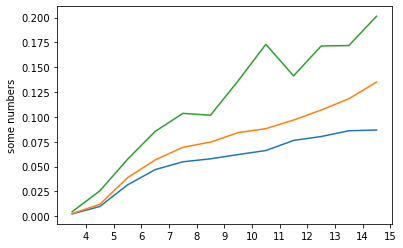

In [135]:
list_min = generate_data_frame_with_stats_from_number_cities(csv_results_dict,
                                  TIME_AND_DATA,
                                  0.9,
                                  0.3,
                                  "time_duration_is_sec ",
                                  "min")
list_avg = generate_data_frame_with_stats_from_number_cities(csv_results_dict,
                                  TIME_AND_DATA,
                                  0.9,
                                  0.3,
                                  "time_duration_is_sec ",
                                  "avg")

list_max = generate_data_frame_with_stats_from_number_cities(csv_results_dict,
                                  TIME_AND_DATA,
                                  0.9,
                                  0.3,
                                  "time_duration_is_sec ",
                                  "max")
print("list_min")
print(list_min)
print("list_avg")
print(list_avg)
print("list_max")
print(list_max)
f2 = pd.DataFrame.from_dict(f)
values = f2.iloc[0]
plt.plot(list_min)
plt.plot(list_avg)
plt.plot(list_max)
xticks_labels = [4,5,6,7,8,9,10,11,12,13,14,15]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
# plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
plt.ylabel('some numbers')
plt.show()
# f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
# fig, ax = plt.subplots(figsize=(15,10))  
# sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
# ax.xaxis.tick_top()
# xticks_labels = [4,5,6,7,8,9,10,11,12,13,14,15]
# yticks_labels = [1]
# plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
# plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# # axis labels
# plt.xlabel('Wartość parametru ALFA')
# plt.ylabel('Wartość parametru BETA')
# # title
# title = 'Odchylenie standardowe długości wykonania w sekundach dla danej wartości parametrów ALFA i BETA dla algorytmu PSO'.upper()
# plt.title(title, loc='left')